In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

## 모델 설계


In [2]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

In [3]:
def create_network() :
    input = Input(shape=(28, 28, 1), name='base_input')  # Updated input shape for convolutional layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1')(input)  # First convolutional layer
    x = MaxPooling2D(pool_size=(2, 2), name='maxpool1')(x)  # First max pooling layer
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2')(x)  # Second convolutional layer
    x = MaxPooling2D(pool_size=(2, 2), name='maxpool2')(x)  # Second max pooling layer
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3')(x)  # Third convolutional layer
    x = MaxPooling2D(pool_size=(2, 2), name='maxpool3')(x)  # Third max pooling layer
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4')(x)  # Fourth convolutional layer
    x = MaxPooling2D(pool_size=(2, 2), name='maxpool4')(x)  # Fourth max pooling layer
    x = Flatten(name='flatten_input')(x)
    x = Dense(128, activation='relu', name='first_base_dense')(x)
    x = Dropout(0.1, name='first_dropout')(x)
    x = Dense(128, activation='relu', name='second_base_dense')(x)
    x = Dropout(0.1, name='second_dropout')(x)
    x = Dense(128, activation='relu', name='third_base_dense')(x)
    
    return Model(inputs = input, outputs = x)

In [4]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, 1e-7))

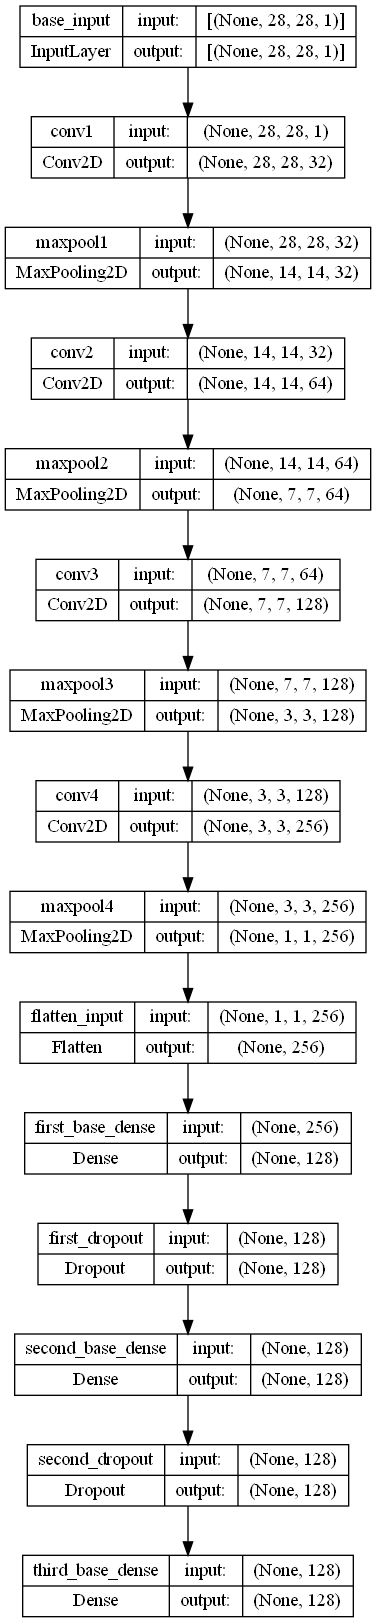

In [5]:
from tensorflow.keras.utils import plot_model
base_model = create_network()
plot_model(base_model, show_shapes=True, show_layer_names=True)

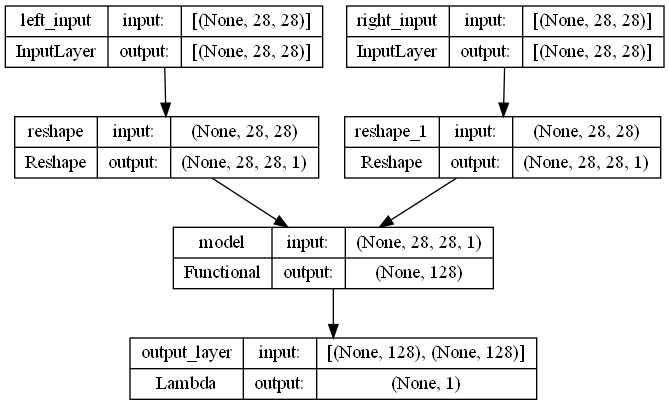

In [6]:
input_a = Input(shape=(28, 28), name='left_input')
input_b = Input(shape=(28, 28), name='right_input')

reshape_a = Reshape((28, 28, 1))(input_a)
reshape_b = Reshape((28, 28, 1))(input_b)

vector_output_a = base_model(reshape_a)
vector_output_b = base_model(reshape_b)

output = Lambda(euclidean_distance, name='output_layer')([vector_output_a, vector_output_b])

# define model
model = Model([input_a, input_b], output)
plot_model(model, show_shapes=True, show_layer_names=True)

In [7]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
        return tf.math.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

rms = RMSprop()

## create dataset

In [8]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [9]:
import numpy as np

random_indices = np.random.choice(x_train.shape[0], 300, replace=False)

x_train_sample, y_train_sample = x_train[random_indices], y_train[random_indices]

x_train_sample.shape, y_train_sample.shape

((300, 28, 28), (300,))

In [10]:
import itertools

def make_pair_dataset(x, y) :
    x_pairs, y_pairs = [], []

    tuples = [(x1, y1) for x1, y1 in zip(x, y)]
    
    for t in itertools.product(tuples, tuples) :
        pair_a, pair_b = t
        img_a, label_a = t[0]
        img_b, label_b = t[1]

        new_label = int(label_a == label_b)

        x_pairs.append([img_a, img_b])
        y_pairs.append(new_label)
    x_pairs = np.array(x_pairs)
    y_pairs = np.array(y_pairs)

    return x_pairs, y_pairs

In [11]:
x_train_pairs, y_train_pairs = make_pair_dataset(x_train_sample, y_train_sample)
x_train_pairs.shape, y_train_pairs.shape

((90000, 2, 28, 28), (90000,))

In [12]:
unique, counts = np.unique(np.reshape(y_train_pairs, (90000,)), return_counts=True)
dict(zip(unique, counts))

{0: 80628, 1: 9372}

In [13]:
random_indices = np.random.choice(x_train.shape[0], 150, replace=False)

x_test_sample, y_test_sample = x_train[random_indices], y_train[random_indices]

x_test_sample.shape, y_test_sample.shape

((150, 28, 28), (150,))

In [14]:
x_test_pairs, y_test_pairs = make_pair_dataset(x_test_sample, y_test_sample)
x_test_pairs.shape, y_test_pairs.shape

((22500, 2, 28, 28), (22500,))

In [15]:
img_a, img_b = x_test[0], x_test[1]
label_a, label_b = y_test[0], y_test[1]

label_a, label_b

(7, 2)

In [16]:
def show_image(image1, label_1, image2, label_2):
    plt.figure(figsize=(8, 4))
    plt.grid(False)
 
    plt.subplot(1,2,1)
    plt.title(label_1)
    plt.imshow(image1)
 
    plt.subplot(1,2,2)
    plt.title(label_2)
    plt.imshow(image2)
    plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_19216\1424263075.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


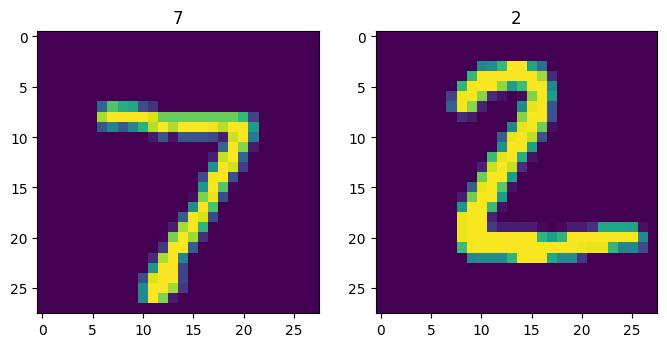

In [17]:
show_image(img_a,label_a, img_b,label_b)

## training model

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
es = EarlyStopping(monitor='val_loss', patience=3)

In [19]:
y_train_pairs_float = y_train_pairs.astype(np.float32)
y_test_pairs_float = y_test_pairs.astype(np.float32)

In [20]:
from keras.utils.data_utils import validate_file
with tf.device("/gpu:0") :
    hist = model.fit(x = [x_train_pairs[:, 0, :, :], x_train_pairs[:, 1, :, :]],
                  y = y_train_pairs_float,
                  validation_data = ([x_train_pairs[:, 0, :, :], 
                                      x_train_pairs[:, 1, :, :]],
                                     y_train_pairs_float),
                  epochs = 200,
                  batch_size=32,
                  callbacks=[es])

Epoch 1/200
2813/2813 [==============================] - 78s 26ms/step - loss: 0.1715 - val_loss: 0.0018
Epoch 2/200
2813/2813 [==============================] - 67s 24ms/step - loss: 5.4094e-04 - val_loss: 2.5892e-05
Epoch 3/200
2813/2813 [==============================] - 67s 24ms/step - loss: 3.2999e-04 - val_loss: 5.9851e-06
Epoch 4/200
2813/2813 [==============================] - 70s 25ms/step - loss: 5.1103e-04 - val_loss: 1.2881e-04
Epoch 5/200
2813/2813 [==============================] - 72s 26ms/step - loss: 9.2255e-04 - val_loss: 8.0148e-04
Epoch 6/200
2813/2813 [==============================] - 71s 25ms/step - loss: 6.8740e-04 - val_loss: 1.4189e-05


In [21]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)
    
loss = model.evaluate([x_test_pairs[:,0, :, :],x_test_pairs[:,1, :, :]],y_test_pairs_float)
 
y_pred_train = model.predict([x_train_pairs[:,0, : ,:], x_train_pairs[:,1, :, :]])
train_accuracy = compute_accuracy(y_train_pairs_float, y_pred_train)
 
y_pred_test = model.predict([x_test_pairs[:,0, :, :], x_test_pairs[:,1, :, :]])
test_accuracy = compute_accuracy(y_test_pairs_float, y_pred_test)
 
print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

704/704 [==============================] - 4s 5ms/step
Loss = 0.019865404814481735, Train Accuracy = 1.0 Test Accuracy = 0.9779555555555556


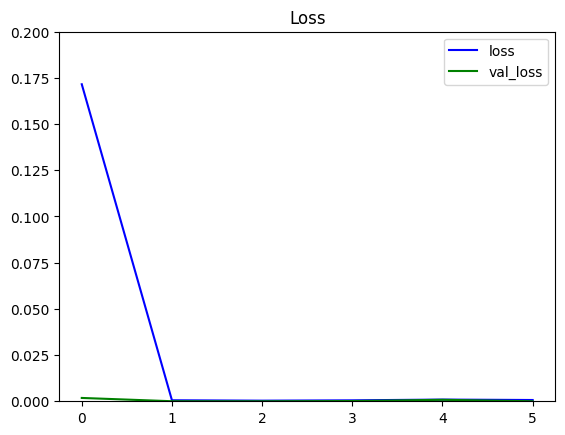

In [22]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(hist.history[metric_name],color='blue',label=metric_name)
    plt.plot(hist.history['val_' + metric_name],color='green',label='val_' + metric_name)
    plt.legend()
    
plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

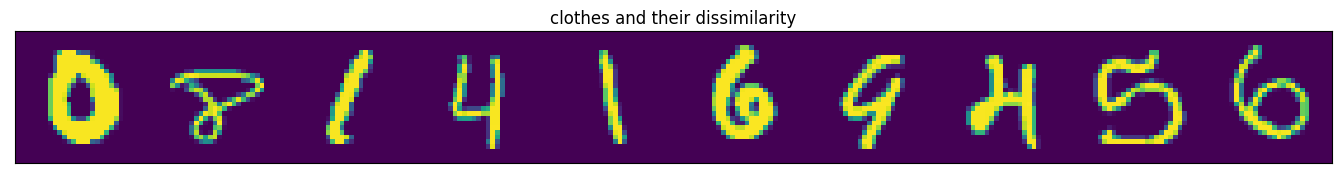

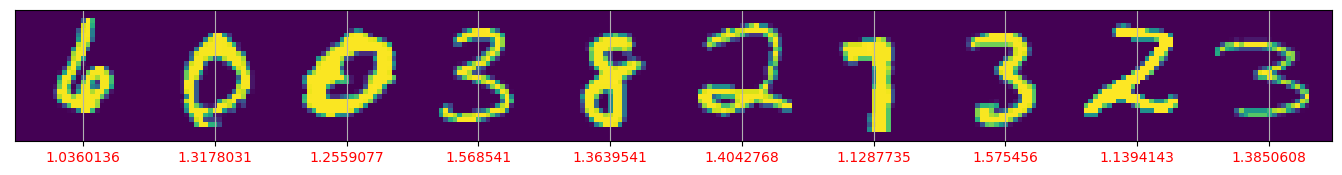

In [23]:
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)
    
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(x_train_pairs[:, 0, :,:][indexes], x_train_pairs[:, 1,:,:][indexes], y_pred_train[indexes], y_train_pairs_float[indexes], "number and their dissimilarity", 10)

In [28]:
model.save('./model/only_siamese_network_addEuclideanDistance.h5')

In [38]:
model.save_weights('./model/weight_of_only_siamese_network_addEuclideanDistance')

In [29]:
unique, counts = np.unique(np.reshape(y_test_pairs, (len(y_test_pairs),)), return_counts=True)
dict(zip(unique, counts))

{0: 20086, 1: 2414}

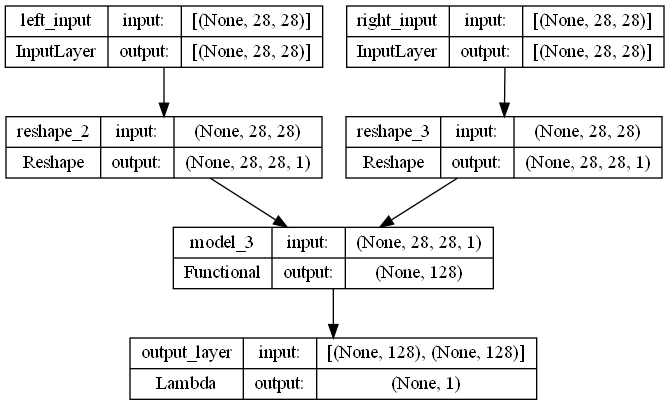

In [49]:
test_base_model = create_network()

input_a = Input(shape=(28, 28), name='left_input')
input_b = Input(shape=(28, 28), name='right_input')

reshape_a = Reshape((28, 28, 1))(input_a)
reshape_b = Reshape((28, 28, 1))(input_b)

vector_output_a = test_base_model(reshape_a)
vector_output_b = test_base_model(reshape_b)

output = Lambda(euclidean_distance, name='output_layer')([vector_output_a, vector_output_b])

# define model
test_model = Model([input_a, input_b], output)

In [50]:
test_model.load_weights('./model/weight_of_only_siamese_network_addEuclideanDistance')

In [51]:
test_model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)

In [53]:
loss = test_model.evaluate([x_test_pairs[:,0, :, :],x_test_pairs[:,1, :, :]],y_test_pairs_float)
 
y_pred_train = test_model.predict([x_train_pairs[:,0, : ,:], x_train_pairs[:,1, :, :]])
train_accuracy = compute_accuracy(y_train_pairs_float, y_pred_train)
 
y_pred_test = test_model.predict([x_test_pairs[:,0, :, :], x_test_pairs[:,1, :, :]])
test_accuracy = compute_accuracy(y_test_pairs_float, y_pred_test)
 
print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

704/704 [==============================] - 4s 5ms/step
Loss = 0.019865404814481735, Train Accuracy = 1.0 Test Accuracy = 0.9779555555555556
